In [4]:
import torch
from torch import nn
import torchvision.models as models
import torchvision
from revuresnet18 import revuresnet18
import warnings
warnings.filterwarnings("ignore")

In [5]:
model = models.resnet18(pretrained = True)
print(model.fc)

Linear(in_features=512, out_features=1000, bias=True)


In [6]:
class Model3d(torch.nn.Module):
    def __init__(self):
        
        super(Model3d, self).__init__()
        self.model = models.resnet18(pretrained = True)
        
        self.model.conv1 = nn.Conv2d(4, 64, 7, stride=2, padding=3, bias=False)
        self.model.avgpool = nn.AdaptiveAvgPool2d(1)
        self.model.fc = nn.Linear(512, 200) #encode_dim =200 (latent vec dim)
        self.encoder = nn.Sequential(self.model)
        
        n_dims=200; 
        nf=512;
        
        self.decoder = nn.Sequential(
            
        nn.ConvTranspose3d(n_dims, nf, 4, stride=1, padding=0, dilation=1, groups=1, bias=True),
        nn.BatchNorm3d(nf, eps=1e-5, momentum=0.1, affine=True),
        nn.ReLU(inplace=True),

        nn.ConvTranspose3d(nf, nf//2, 4, stride=2, padding=1, dilation=1, groups=1, bias=True),
        nn.BatchNorm3d(nf//2, eps=1e-5, momentum=0.1, affine=True),
        nn.ReLU(inplace=True),

        nn.ConvTranspose3d(nf//2, nf//4, 4, stride=2, padding=1, dilation=1, groups=1, bias=True),
        nn.BatchNorm3d(nf//4, eps=1e-5, momentum=0.1, affine=True),
        nn.ReLU(inplace=True),

        nn.ConvTranspose3d(nf//4, nf//8, 4, stride=2, padding=1, dilation=1, groups=1, bias=True),
        nn.BatchNorm3d(nf//8, eps=1e-5, momentum=0.1, affine=True),
        nn.ReLU(inplace=True),

        nn.ConvTranspose3d(nf//8, nf//16, 4, stride=2, padding=1, dilation=1, groups=1, bias=True),
        nn.BatchNorm3d(nf//16, eps=1e-5, momentum=0.1, affine=True),
        nn.ReLU(inplace=True),
        nn.ConvTranspose3d(nf//16, 1, 4, stride=2, padding=1, dilation=1, groups=1, bias=True)
        )



    def forward(self,x):
        latent_vec = self.encoder(x.float())
        latent_vec = latent_vec.view(latent_vec.size(0), -1, 1, 1, 1)
        vox = self.decoder(latent_vec)
        
        return vox;
        
    
        

In [29]:
class Trainer():
    def __init__(self,model):
        self.model = model
        
    def preprocess_inp(self,inp):
        
        normal = inp['normal']
        depth = inp['depth']
        sil = inp['sil']

        normal = normal.transpose(2,0,1).reshape(-1,3,480,480)
        depth = depth.transpose(2,0,1)
        depth = depth[0,:,:].reshape(-1,1,480,480)
        sil = sil.transpose(2,0,1)
        sil = sil[0,:,:].reshape(-1,1,480,480)

        normal = torch.from_numpy(normal)
        depth = torch.from_numpy(depth)
        sil = torch.from_numpy(sil)


#         print("Normal:", normal.shape)
#         print("Depth:", depth.shape)
#         print("Silhouette:", sil.shape)


        is_bg = sil <= 0 #self.silhou_thres
#         print(type(is_bg))
        depth[is_bg] = 0
        normal[is_bg.repeat(1, 3, 1, 1)] = 0 # NOTE: if old net2, set to white (100),
        x = torch.cat((depth, normal), 1) # and swap depth and normal


        
        
#         normal = cv2.resize(inp['normal'], (256,256))
#         depth = cv2.resize(inp['depth'], (256,256))
#         sil = cv2.resize(inp['sil'], (256,256))
                
#         transform = torchvision.transforms.ToTensor()
#         normal = transform(normal).unsqueeze(0)
#         depth = transform(depth).unsqueeze(0)
#         sil = transform(sil).unsqueeze(0)
        
#         inp['normal'] = normal
#         inp['depth'] = depth
#         inp['sil'] = sil
        
        
#         is_bg = sil <= 0 #self.silhou_thres
#         print(type(is_bg))
#         depth[is_bg] = 0
#         normal[is_bg.repeat(1, 3, 1, 1)] = 0 # NOTE: if old net2, set to white (100),
#         x = torch.cat((depth, normal), 1) # and swap depth and normal


        return x
    
    def preprocess_labels(self,labels):
        
        label = labels['voxel']
        transform = torchvision.transforms.ToTensor()
        label = transform(label).unsqueeze(0)
        label = label.unsqueeze(0)
        return label
    
        
    def train(self, model):
        
        num_epochs = 1000
        num_batch  = 1
        criterion = torch.nn.BCEWithLogitsLoss(reduction = 'elementwise_mean')
        optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
        
        
        for epoch in range(num_epochs):
            
            for batch in range(num_batch):
                
                # Load data and labels of that batch
                
                inp = {}
                inp['normal'] = cv2.imread("temp_results/normal.png")
                inp['sil'] = cv2.imread("temp_results/sil.png")
                inp['depth'] = cv2.imread("temp_results/depth.png")
                
            
                inp = self.preprocess_inp(inp)                
                
                
                
                
                label = np.load("temp_results/3d_128.npz")
                
                label = self.preprocess_labels(label)
                
             
                output = model.forward(inp)
                #output = torch.clamp(output,0,1) 
                
            
                
#                 loss_normal = criterion(output['normal'], labels_bat['normal'])
#                 loss_depth = criterion(output['depth'], labels_bat['depth'])
#                 loss_sil = criterion(output['sil'], labels_bat['sil'])

                loss = criterion(output,label.type(torch.FloatTensor))         
            
                if epoch % 100 == 99:
                    
                    print("Epoch: ", epoch , "Loss: ", loss.item())

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
        return model
                

model = Model3d()
trainer = Trainer(model)
trained_model = trainer.train(model)


Epoch:  99 Loss:  0.025534184649586678
Epoch:  199 Loss:  0.011543563567101955
Epoch:  299 Loss:  0.007882954552769661
Epoch:  399 Loss:  0.006504843942821026
Epoch:  499 Loss:  0.005912172142416239
Epoch:  599 Loss:  0.005634625442326069
Epoch:  699 Loss:  0.00536873284727335
Epoch:  799 Loss:  0.005205672699958086
Epoch:  899 Loss:  0.0050835320726037025
Epoch:  999 Loss:  0.0049677821807563305


In [16]:
import numpy as np
import cv2

depth = cv2.imread("temp_results/depth.png")
normal = cv2.imread("temp_results/normal.png")
sil = cv2.imread("temp_results/sil.png")



normal = normal.transpose(2,0,1).reshape(-1,3,480,480)
depth = depth.transpose(2,0,1)
depth = depth[0,:,:].reshape(-1,1,480,480)
sil = sil.transpose(2,0,1)
sil = sil[0,:,:].reshape(-1,1,480,480)

normal = torch.from_numpy(normal)
depth = torch.from_numpy(depth)
sil = torch.from_numpy(sil)


print("Normal:", normal.shape)
print("Depth:", depth.shape)
print("Silhouette:", sil.shape)


is_bg = sil <= 0 #self.silhou_thres
print(type(is_bg))
depth[is_bg] = 0
normal[is_bg.repeat(1, 3, 1, 1)] = 0 # NOTE: if old net2, set to white (100),
x = torch.cat((depth, normal), 1) # and swap depth and normal

# model = Model3d()
V = trained_model.forward(x)

Normal: torch.Size([1, 3, 480, 480])
Depth: torch.Size([1, 1, 480, 480])
Silhouette: torch.Size([1, 1, 480, 480])
<class 'torch.Tensor'>


In [17]:
# print(L.shape)
V = V.detach().numpy().squeeze()
print(V.shape)

(128, 128, 128)


In [27]:
temp = np.where(V < 0.5, 0, 1)


In [31]:
label = np.load("temp_results/3d_128.npz")
label = label['voxel']

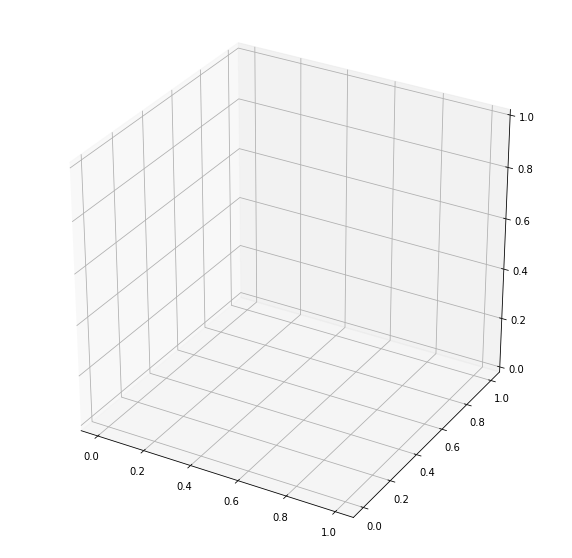

In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

z,x,y = temp.nonzero()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, -z, zdir='z', c = 'red')
#ax.view_init(azim=65)
plt.show()


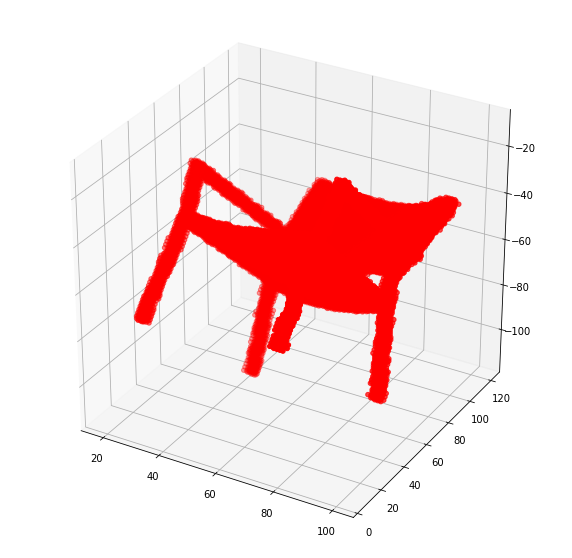

32263 32263 32263


In [33]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

z,x,y = label.nonzero()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, -z, zdir='z', c= 'red')
#ax.view_init(azim=-180)
plt.show()
print(len(z),len(x),len(y))


In [152]:
print(V)

[[[-19.04925  -19.607857 -24.77395  ... -17.285864 -23.317823  -8.364289]
  [-25.22146  -40.794304 -36.539692 ... -34.230774 -34.080368 -22.705936]
  [-26.280714 -31.842031 -36.321285 ... -26.658543 -34.64331  -18.046412]
  ...
  [-23.776846 -37.92514  -34.900536 ... -30.970053 -32.81279  -23.593336]
  [-26.800493 -33.462486 -40.218597 ... -30.14715  -40.77327  -20.28219 ]
  [-15.682866 -31.340021 -28.897915 ... -30.54193  -29.857153 -21.333443]]

 [[-25.046902 -37.50479  -34.365387 ... -31.711363 -32.462784 -20.890322]
  [-35.146446 -50.977425 -44.861385 ... -40.647644 -43.35135  -30.621042]
  [-33.192528 -46.363773 -40.40406  ... -33.700394 -36.878403 -28.16154 ]
  ...
  [-31.958616 -43.035385 -35.47314  ... -33.82598  -37.904305 -28.874716]
  [-33.709824 -49.85952  -43.027985 ... -44.207382 -48.190147 -33.29368 ]
  [-22.724545 -37.16754  -34.61708  ... -36.014    -37.19097  -25.304928]]

 [[-24.759457 -29.31001  -33.51996  ... -24.711943 -31.820723 -16.472101]
  [-34.637753 -52.7256